In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('filtered_gdp.csv')

# Display the first few rows of the DataFrame
print(df.head())

  ISO code               Country Variable code  \
0      AGO                Angola         cgdpe   
1      ALB               Albania         cgdpe   
2      ARE  United Arab Emirates         cgdpe   
3      ARG             Argentina         cgdpe   
4      ARM               Armenia         cgdpe   

                                       Variable name         1950  \
0  Expenditure-side real GDP at current PPPs (in ...          NaN   
1  Expenditure-side real GDP at current PPPs (in ...          NaN   
2  Expenditure-side real GDP at current PPPs (in ...          NaN   
3  Expenditure-side real GDP at current PPPs (in ...  49204.30078   
4  Expenditure-side real GDP at current PPPs (in ...          NaN   

          1951         1952         1953         1954         1955  ...  \
0          NaN          NaN          NaN          NaN          NaN  ...   
1          NaN          NaN          NaN          NaN          NaN  ...   
2          NaN          NaN          NaN          NaN      

In [3]:
gdp_columns = df.columns.difference(['ISO code', 'Country', 'Variable code', 'Variable name'])

# Select only the GDP data for the United States
gdp_data = df[gdp_columns]

# Convert the GDP data to numeric, forcing any errors to NaN
gdp_data = gdp_data.apply(pd.to_numeric, errors='coerce')

# Display the new DataFrame
max_gdp = gdp_data.max(axis=1).values[0]
min_gdp = gdp_data.min(axis=1).values[0]


In [4]:
year_columns = df.columns[4:]
# Calculate the logarithm of the GDP values
log_gdp = np.log(df[year_columns])

# Calculate the difference in logs (log(GDP_t) - log(GDP_{t-1}))
log_diff = log_gdp.diff(axis=1)

log_diff = log_diff.drop(log_diff.columns[0], axis=1)

# Rename columns to indicate they are log differences
log_diff.columns = [f'log_diff_{col}' for col in log_diff.columns]

# Combine with original DataFrame
df_combined = pd.concat([df.iloc[:, :4], log_diff], axis=1)
# Display the new DataFrame
max_gdp1 = log_diff.max(axis=1).values[0]
min_gdp1 = log_diff.min(axis=1).values[0]


In [5]:
test = "Albania"

# Print the mean GDP for 'United States'
print(f"Mean GDP change for {test}': {df_combined[df_combined["Country"] == test].iloc[:, 4:].mean(axis=1)}")

# # Display the resulting DataFrame
print(df_combined.head())

Mean GDP change for Albania': 1    0.035771
dtype: float64
  ISO code               Country Variable code  \
0      AGO                Angola         cgdpe   
1      ALB               Albania         cgdpe   
2      ARE  United Arab Emirates         cgdpe   
3      ARG             Argentina         cgdpe   
4      ARM               Armenia         cgdpe   

                                       Variable name  log_diff_1951  \
0  Expenditure-side real GDP at current PPPs (in ...            NaN   
1  Expenditure-side real GDP at current PPPs (in ...            NaN   
2  Expenditure-side real GDP at current PPPs (in ...            NaN   
3  Expenditure-side real GDP at current PPPs (in ...       0.046533   
4  Expenditure-side real GDP at current PPPs (in ...            NaN   

   log_diff_1952  log_diff_1953  log_diff_1954  log_diff_1955  log_diff_1956  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN       

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import cauchy

In [7]:
distributions = {}
for country,data in df_combined.groupby('Country'):
    values = data.iloc[:, 4:].values.flatten()
    values = values[np.isfinite(values)]
    params = cauchy.fit(values)
    distributions[country] = [params[0],params[1], values.min(), values.max()]   


In [8]:
print(distributions["Albania"])

[0.04015352757187253, 0.022034147355667708, -0.25244803263174376, 0.20101411074678488]


(0.04015352757187253, 0.022034147355667708)


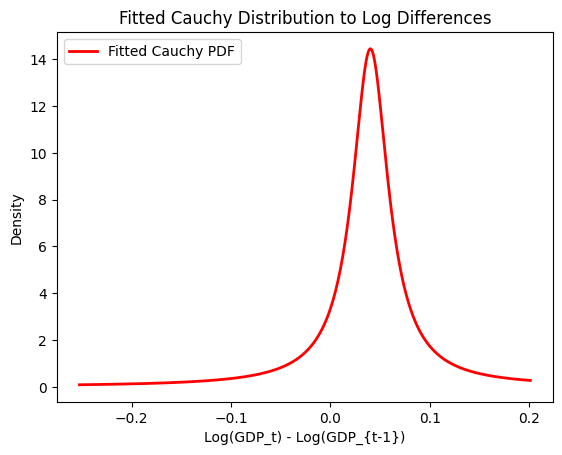

In [9]:
Country ="Albania"
data = distributions[Country]
params = (data[0],data[1])
min = data[2]
max = data[3]
print(params)
# Generate a range of x values for the plot
x = np.linspace(min, max, 1000)
# Get the fitted Cauchy distribution's PDF
pdf_fitted = cauchy.pdf(x, *params)

# Plot the fitted Cauchy distribution
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Cauchy PDF')

# Add labels and legend
plt.xlabel('Log(GDP_t) - Log(GDP_{t-1})')
plt.ylabel('Density')
plt.title('Fitted Cauchy Distribution to Log Differences')
plt.legend()

# Show the plot
plt.show()

In [14]:
import csv
import numpy as np
import matplotlib.pyplot as plt


# Function to compute the transformed Cauchy PDF
def transformed_cauchy_pdf(y, GDP0, n, x0, gamma):
    ln_term = np.log(y / GDP0)
    return 1 / (np.pi * gamma * y * (1 + ((ln_term - n * x0) / gamma) ** 2))

def get_transformed_cauchy_params(n, x0, gamma):
    # Transformed location and scale
    location = n * x0
    scale = gamma
    return location, scale

# Parameters
GDP0 = df[df["Country"] == Country]["2019"].iloc[0]  # Initial GDP in million dollars
x0 = params[0]  # Median growth rate (2%)
gamma = params[1] # Scale parameter (1%)
print(GDP0)

# for country in df["Country"]:
#     # Plot PDFs for 1 to 5 future years
with open('gdp_dist.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    header = ['Country', 'Year', 'loc', 'sca', 'mode']
    writer.writerow(header)
    for n in range(1,82):  # Years 1 through 5
        mode = GDP0 * np.exp(n * x0)  # Mode of the distribution for year n
        y_values = np.linspace(mode / 2, mode * 2, 2000)
        pdf_values = transformed_cauchy_pdf(y_values, GDP0, n, x0, gamma)
        # Call the function and store the results
        # location, scale = get_transformed_cauchy_params(n, x0, gamma)
        writer.writerow([Country,2018+n,x0,gamma,mode])

# # Customize the plot
# plt.title('Probability Density Function of Future GDP Over Years')
# plt.xlabel('Future GDP (million dollars)')
# plt.ylabel('Probability Density')
# # plt.legend()
# plt.grid(True)

# # Show the plot
# plt.show()

35808.34375
